In [44]:
# should use a vcf with SNPs but not with heavy filters. 
# only biallelic might speed things up, but do I miss out on important loci?

````bash
bcftools view -V indels,mnps,ref,bnd,other 1011Matrix.gvcf.gz | bcftools view -s AAA | bcftools view -i "AC>0 & FORMAT/DP > 10" | bcftools query -f "[%AD]\n" | gzip > 1011Matrix.gvcf.gz-AAA.AD.csv.gz
````

In [63]:
source("../BrusselSprouts/scripts/functions.R")

In [64]:
# out paste(args[1],".polyploid.score",sep="") <- folder schould be AD

In [65]:
samples=readLines("~/data/TRD/1011Matrix.gvcf.gz.samples")
length(samples)

[1] 1011

In [66]:
initial_timedate=Sys.time()
scripts_dir="/home/jnrunge/data/TRD/AD/scripts/"
jobname="Scev-ploidy"
sbatch_list=paste(scripts_dir,jobname,"-sbatch.list", sep="")
print(sbatch_list)
if(file.exists(sbatch_list)){
    system(command=paste("rm -f ", sbatch_list, sep=""))
}

for(s in samples){
    
    if(!file.exists(paste("~/data/TRD/AD/",s,".AD.csv.gz.polyploid.score",sep="")))
    {
        sbatch=paste("#!/bin/bash
#SBATCH -p fast          # The account name for the job
#SBATCH --job-name=",jobname,"  # The job name
#SBATCH -o ",scripts_dir,"logs/",jobname,"-",s,".out
#SBATCH -e ",scripts_dir,"logs/",jobname,"-",s,".err
#SBATCH -c 1                 # The number of cpu cores to use
#SBATCH --time=11:59:00       # The time the job will take to run 
#SBATCH --mem=4gb

date
source ~/anaconda3/etc/profile.d/conda.sh
conda activate bwaetc

cd ~/data/TRD/

bcftools view -V indels,mnps,ref,bnd,other 1011Matrix.gvcf.gz | bcftools view -s ",s," | bcftools view -i 'AC>0 & FORMAT/DP > 10' | bcftools query -f '[%AD]\\n' | gzip > AD/",s,".AD.csv.gz

conda activate JupyteR4

Rscript ~/TRD/scripts/polyploidy.R AD/",s,".AD.csv.gz AD/",s,".AD.csv.gz.polyploid.score

conda activate JupyteR4
Rscript ~/BrusselSprouts/scripts/Execute_Sbatches.R '",initial_timedate,"' ",sbatch_list," 20 ",jobname,"

date
",sep="")
        sbatch_file=paste("~/data/bruxellensis/mapping/scripts/",jobname,"-",s,".sbatch",sep="")
        #print(sbatch_file)
        writeLines(sbatch, sbatch_file)

        write(sbatch_file,file=sbatch_list,append=TRUE)


            
        }
}


print(system(command=paste("wc -l ", sbatch_list, sep=""),intern=TRUE))



[1] "/home/jnrunge/data/TRD/AD/scripts/Scev-ploidy-sbatch.list"
[1] "371 /home/jnrunge/data/TRD/AD/scripts/Scev-ploidy-sbatch.list"


In [67]:
print(system(command=paste("Rscript ~/BrusselSprouts/scripts/Execute_Sbatches.R '",initial_timedate,"' ",sbatch_list," 20 ",jobname, "30", sep=""), intern=TRUE))

 [1] "[1] \"Currently running 0 jobs.\""                 
 [2] "[1] \"371 sbatches remaining! Running 21 more...\""
 [3] "[1] \"Submitted batch job 272514\""                
 [4] "[1] \"Submitted batch job 272522\""                
 [5] "[1] \"Submitted batch job 272523\""                
 [6] "[1] \"Submitted batch job 272524\""                
 [7] "[1] \"Submitted batch job 272525\""                
 [8] "[1] \"Submitted batch job 272526\""                
 [9] "[1] \"Submitted batch job 272527\""                
[10] "[1] \"Submitted batch job 272528\""                
[11] "[1] \"Submitted batch job 272529\""                
[12] "[1] \"Submitted batch job 272530\""                
[13] "[1] \"Submitted batch job 272531\""                
[14] "[1] \"Submitted batch job 272532\""                
[15] "[1] \"Submitted batch job 272533\""                
[16] "[1] \"Submitted batch job 272534\""                
[17] "[1] \"Submitted batch job 272535\""                
[18] "[1] \"Su

In [70]:
polyfiles=system(command="ls ~/data/TRD/AD/*.AD.csv.gz.polyploid.score",intern=TRUE)
length(polyfiles)

[1] 1011

In [71]:
poly_df=data.frame(file=polyfiles, score=NA, stringsAsFactors = FALSE)
for(i in 1:nrow(poly_df)){
    poly_df$score[i]=as.numeric(readLines(poly_df$file[i]))
}

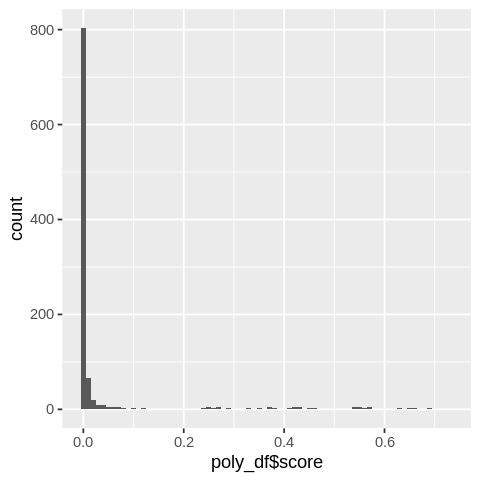

In [81]:
options(repr.plot.width=4, repr.plot.height=4)

ggplot(mapping=aes(poly_df$score))+
geom_histogram(binwidth = 0.01)

In [80]:
writeLines(unlist(lapply(unlist(lapply(poly_df$file[poly_df$score<0.01], getLast, split="/")),getFirst_v2,split=".")), "~/data/TRD/AD/notPolyploid.list")